<a href="https://colab.research.google.com/github/yuvalofek/scraping-light-novel-data/blob/main/LN_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## An analysis of the light novel dataset I scraped 

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import ttest_ind

In [43]:
DATA_PATH = '/content/drive/MyDrive/light_novel_dataset.csv'

ln_df = pd.read_csv(DATA_PATH)
ln_df.head()

,Unnamed: 0,title,Type,Genre,Tags,Language,Author(s),Artist(s),Year,Status,Description,You May Also Like,Total Views,Rating,Latest Chapters,chap_count,rand_chapter,Alternative Names,Related Series
0,0,A Bored Lich,['Web Novel'],['Fantasy'],['N/A'],['Chinese'],['Random_writer'],['N/A'],['N/A'],['Ongoing'],"['""Screw magic, I want to learn how to do cool...",['Ore ga Inmajutsu de Dorei Harem wo Tsukuru H...,['65133'],['7.3'],"['Chapter 321', ' Chapter 320', ' Chapter 319'...",321.0,5.0,NaN,NaN
1,1,A Billion Dollar Exchange,['Web Novel'],['Romance'],['N/A'],['Chinese'],['ZhiRuYi'],['N/A'],['N/A'],['Ongoing'],"['""Mr Liu Wei.."" Liling paused as she took In ...","['May Your Soul Rest in Magdala(Ongoing)', 'Fi...",['56356'],['7.7'],"['Chapter 339', ' Chapter 338', ' Chapter 337'...",339.0,31.0,NaN,NaN
2,2,"A Boy Raised by Gods, Will Be the Strongest",['Web Novel'],"['Action', 'Adventure', 'Fantasy', 'Harem', 'R...",['N/A'],['Japanese'],['Hata Ryosuke'],['N/A'],['N/A'],['Ongoing'],['Will was a boy left to his fate in the middl...,"['So Pure, So Flirtatious(Ongoing)', 'The Roma...",['14834'],['7.8'],"['Chapter 15', ' Chapter 14', ' Chapter 13', '...",15.0,1.0,"['Kamigami ni Sodaterare Shimo no, Saikyou to ...",NaN
3,3,A Book Dedicated to Our Youth,['Chinese Novel'],"['Josei', 'Romance']","['Bullying', 'First Love', 'Smart Female Lead']",['Chinese'],['Tong Hua'],['Tong Hua'],['2010'],['Ongoing'],['There are always moments far in the past tha...,['Harmless Obsession for the Captivating Male ...,['26740'],['2.6'],"['Epilogue', ' Chapter 8.3', ' Chapter 8.2', '...",4.0,49.0,"['Time Will Never Go Back', '那些回不去的年少时光']",NaN
4,4,A Barbaric Proposal,['Web Novel'],"['Drama', 'Fantasy', 'Josei', 'Romance']",['N/A'],['Korean'],['齐成琨'],['N/A'],['N/A'],['Ongoing'],"['“I already have a child with another man.”',...","['GosickS(Ongoing)', 'My Forgiving Fiancee Is ...",['24791'],['7.5'],"['Chapter 52', ' Chapter 51', ' Chapter 50', '...",52.0,15.0,['ABP 야만의 청혼'],NaN


## Cleaning the data
* Drop unamed column
* We need to remove the \[ \] on a bunch of the columns
* Readers -> int
* Rating, chap_count -> float
* Drop random chapter (as the word count data didn't get saved)
* One hot some of the columns (genre, type, tags, language)
* Format description for NLP



In [44]:
# drop extra index col
ln_df.drop('Unnamed: 0', axis=1, inplace=True)
ln_df.drop('rand_chapter', axis=1, inplace=True)

In [45]:
for col in ln_df.columns:
  if ln_df[col].dtype == type(object):
    # if we have an object type, remove the brackets and \'
    ln_df[col] = ln_df[col].str.replace("\[|\]|\'", '')

In [46]:
ln_df.head()

,title,Type,Genre,Tags,Language,Author(s),Artist(s),Year,Status,Description,You May Also Like,Total Views,Rating,Latest Chapters,chap_count,Alternative Names,Related Series
0,A Bored Lich,Web Novel,Fantasy,N/A,Chinese,Random_writer,N/A,N/A,Ongoing,"""Screw magic, I want to learn how to do cool f...",Ore ga Inmajutsu de Dorei Harem wo Tsukuru Han...,65133,7.3,"Chapter 321, Chapter 320, Chapter 319, Chap...",321.0,NaN,NaN
1,A Billion Dollar Exchange,Web Novel,Romance,N/A,Chinese,ZhiRuYi,N/A,N/A,Ongoing,"""Mr Liu Wei.."" Liling paused as she took In a ...","May Your Soul Rest in Magdala(Ongoing), Findin...",56356,7.7,"Chapter 339, Chapter 338, Chapter 337, Chap...",339.0,NaN,NaN
2,"A Boy Raised by Gods, Will Be the Strongest",Web Novel,"Action, Adventure, Fantasy, Harem, Romance, Sh...",N/A,Japanese,Hata Ryosuke,N/A,N/A,Ongoing,Will was a boy left to his fate in the middle ...,"So Pure, So Flirtatious(Ongoing), The Romantic...",14834,7.8,"Chapter 15, Chapter 14, Chapter 13, Chapter...",15.0,"Kamigami ni Sodaterare Shimo no, Saikyou to Na...",NaN
3,A Book Dedicated to Our Youth,Chinese Novel,"Josei, Romance","Bullying, First Love, Smart Female Lead",Chinese,Tong Hua,Tong Hua,2010,Ongoing,There are always moments far in the past that ...,Harmless Obsession for the Captivating Male Le...,26740,2.6,"Epilogue, Chapter 8.3, Chapter 8.2, Chapter...",4.0,"Time Will Never Go Back, 那些回不去的年少时光",NaN
4,A Barbaric Proposal,Web Novel,"Drama, Fantasy, Josei, Romance",N/A,Korean,齐成琨,N/A,N/A,Ongoing,"“I already have a child with another man.”, It...","GosickS(Ongoing), My Forgiving Fiancee Is a Co...",24791,7.5,"Chapter 52, Chapter 51, Chapter 50, Chapter...",52.0,ABP 야만의 청혼,NaN


### One-hotting

In [47]:
def get_unique_from_lists(col, delimiter=','):
  """
  Take a column whose values are lists split by delimiter and finds the unique
  values across all the lists
  """
  # split the string on \, , explode to get each on a different index, remove "/'"s, strip, and get unique values
  genres_ = ln_df[col].str.split(delimiter).explode().str.strip().unique().tolist()
  # remove empty string
  genres_.remove('')  
  return genres_

#### Genre

In [48]:
### Genre_list
genres = get_unique_from_lists('Genre')

In [49]:
# create a column for each genre and see if the novel has the genre
for genre in genres:
  ln_df['Genre_'+genre] = ln_df['Genre'].str.find(genre) != -1
ln_df.drop('Genre', axis=1, inplace=True)

#### Tags

In [50]:
### Genre_list
tags = get_unique_from_lists('Tags')

In [51]:
for tag in tags:
  ln_df['Tag_'+tag] = ln_df['Tags'].str.find(tag) != -1
ln_df.drop('Tags', axis=1, inplace=True)

#### Some column drops

In [52]:
# Drop novels with na chapter counts --> indicates that the novel is either too short for our analysis
# Or is formatted differently than we expect
ln_df = ln_df[~ln_df['chap_count'].isna()]

### Casting

In [53]:
ln_df['Total Views']= ln_df['Total Views'].astype(int)
ln_df['Rating']= ln_df['Rating'].astype(float)
ln_df['chap_count']= ln_df['chap_count'].astype(int)


##### Strings to lists

In [54]:
ln_df['You May Also Like'] = ln_df['You May Also Like'].str.split(',')
ln_df['Latest Chapters'] = ln_df['Latest Chapters'].str.split(',')


In [55]:
ln_df.head()

,title,Type,Language,Author(s),Artist(s),Year,Status,Description,You May Also Like,Total Views,Rating,Latest Chapters,chap_count,Alternative Names,Related Series,Genre_Fantasy,Genre_Romance,Genre_Action,Genre_Adventure,Genre_Harem,Genre_Shounen,Genre_Josei,Genre_Drama,Genre_Martial Arts,Genre_Slice of Life,Genre_Yaoi,Genre_Comedy,Genre_Xianxia,Genre_Xuanhuan,Genre_Historical,Genre_Mature,Genre_Wuxia,Genre_Shoujo,Genre_Supernatural,Genre_School Life,Genre_Mecha,Genre_Sci-fi,Genre_Shounen Ai,Genre_Psychological,Genre_Mystery,...,Tag_Sword Sects,Tag_Subtle Romantic Subplot,Tag_Smithing,Tag_Sadistic Teacher,Tag_Pokerface,Tag_Pill Concoction,Tag_Masochistic Training,Tag_Leveling Up,Tag_Jack Of All Trades,Tag_Hot-blooded,Tag_Farming,Tag_Cunning Protagonist,Tag_Master-Disciple Relationship,Tag_Dishonest Protagonist,Tag_Manipulative Female Lead,Tag_Ruthless Female Lead,Tag_Blind Protagonist,Tag_Egotistical Male Lead,Tag_Concubine,Tag_Fantasy World Magic,Tag_Sword And Magic,Tag_Clingy Lover,Tag_Miscarriage,Tag_Poor Female Lead,Tag_Hardworking Female Lead,Tag_Lazy Male Lead,Tag_Demon Child,Tag_Apathetic Protagonist,Tag_English Company Closed Before Completing,Tag_Forgetful Protagonist,Tag_Bibles,Tag_Pedophile,Tag_Explicit Sexual Content,Tag_deneme,Tag_Out Of Print In English,Tag_Action,Tag_Digital World,Tag_Video Game Industry,Tag_School Clubs,Tag_Search For Oneself
0,A Bored Lich,Web Novel,Chinese,Random_writer,N/A,N/A,Ongoing,"""Screw magic, I want to learn how to do cool f...",[Ore ga Inmajutsu de Dorei Harem wo Tsukuru Ha...,65133,7.3,"[Chapter 321, Chapter 320, Chapter 319, ...",321,NaN,NaN,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,A Billion Dollar Exchange,Web Novel,Chinese,ZhiRuYi,N/A,N/A,Ongoing,"""Mr Liu Wei.."" Liling paused as she took In a ...","[May Your Soul Rest in Magdala(Ongoing), Find...",56356,7.7,"[Chapter 339, Chapter 338, Chapter 337, ...",339,NaN,NaN,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,"A Boy Raised by Gods, Will Be the Strongest",Web Novel,Japanese,Hata Ryosuke,N/A,N/A,Ongoing,Will was a boy left to his fate in the middle ...,"[So Pure, So Flirtatious(Ongoing), The Roman...",14834,7.8,"[Chapter 15, Chapter 14, Chapter 13, Cha...",15,"Kamigami ni Sodaterare Shimo no, Saikyou to Na...",NaN,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,A Book Dedicated to Our Youth,Chinese Novel,Chinese,Tong Hua,Tong Hua,2010,Ongoing,There are always moments far in the past that ...,[Harmless Obsession for the Captivating Male L...,26740,2.6,"[Epilogue, Chapter 8.3, Chapter 8.2, Cha...",4,"Time Will Never Go Back, 那些回不去的年少时光",NaN,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,

## Exploration

### Chapter Counts

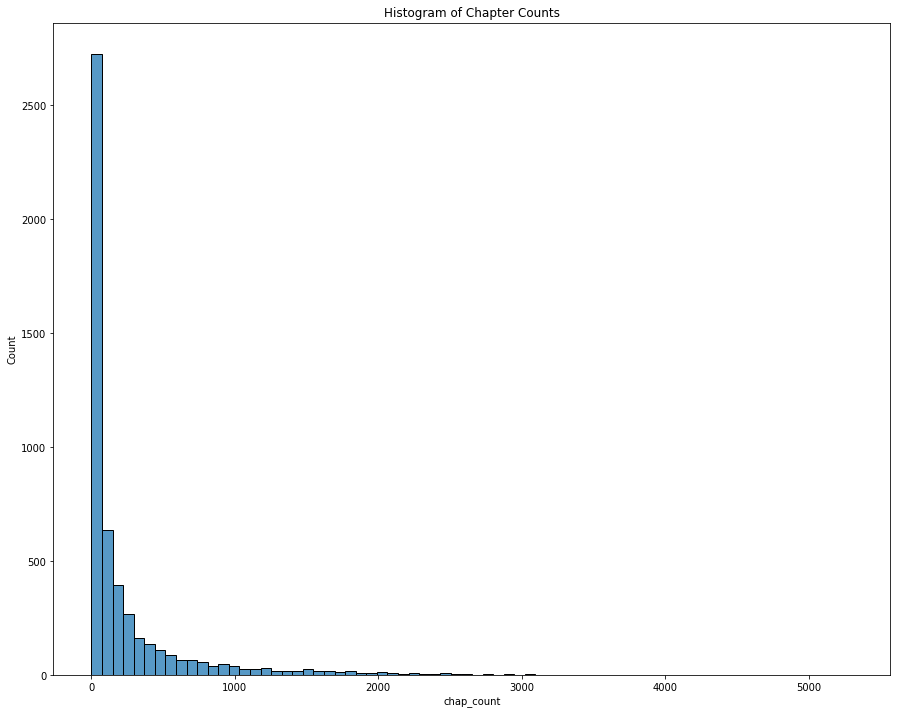

In [56]:
# Histogram of lengths
plt.figure(figsize=(15, 12))
plt.title('Histogram of Chapter Counts')
sns.histplot(ln_df['chap_count'], bins = int(np.ceil(np.sqrt(len(ln_df)))))
plt.show()

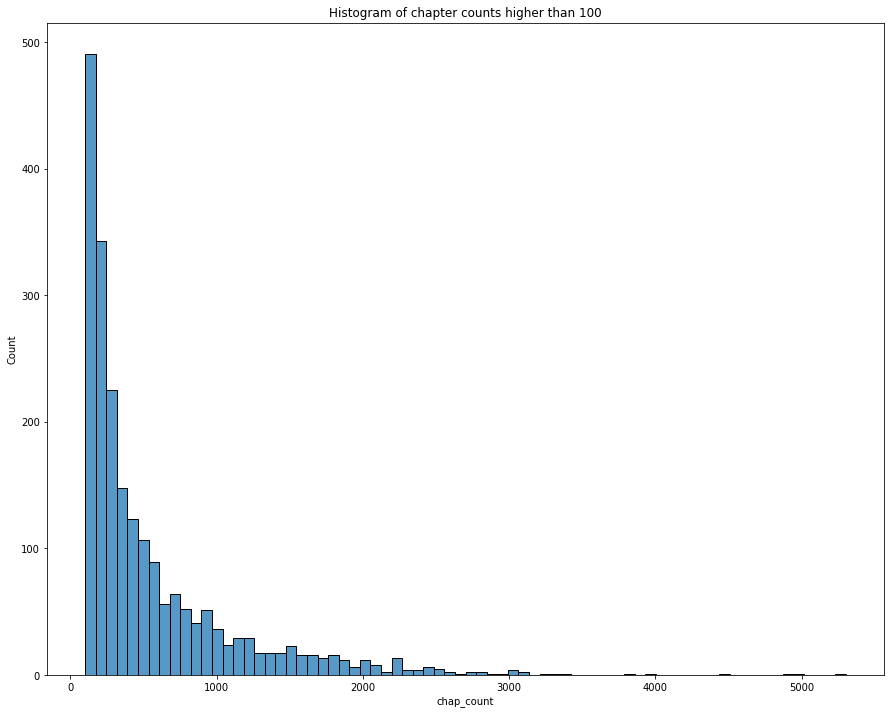

In [57]:
# This serves to visualize the distribution of the novels that have significant progress
N = 100
plt.figure(figsize=(15, 12))
plt.title(f'Histogram of chapter counts higher than {N}')
sns.histplot(ln_df[ln_df['chap_count']>N]['chap_count'], bins= int(np.ceil(np.sqrt(len(ln_df)))))
plt.show()

We definitely expect this sort of exponential decay pattern, so there doesn't seem to be too much of a discrepancy

### Genre

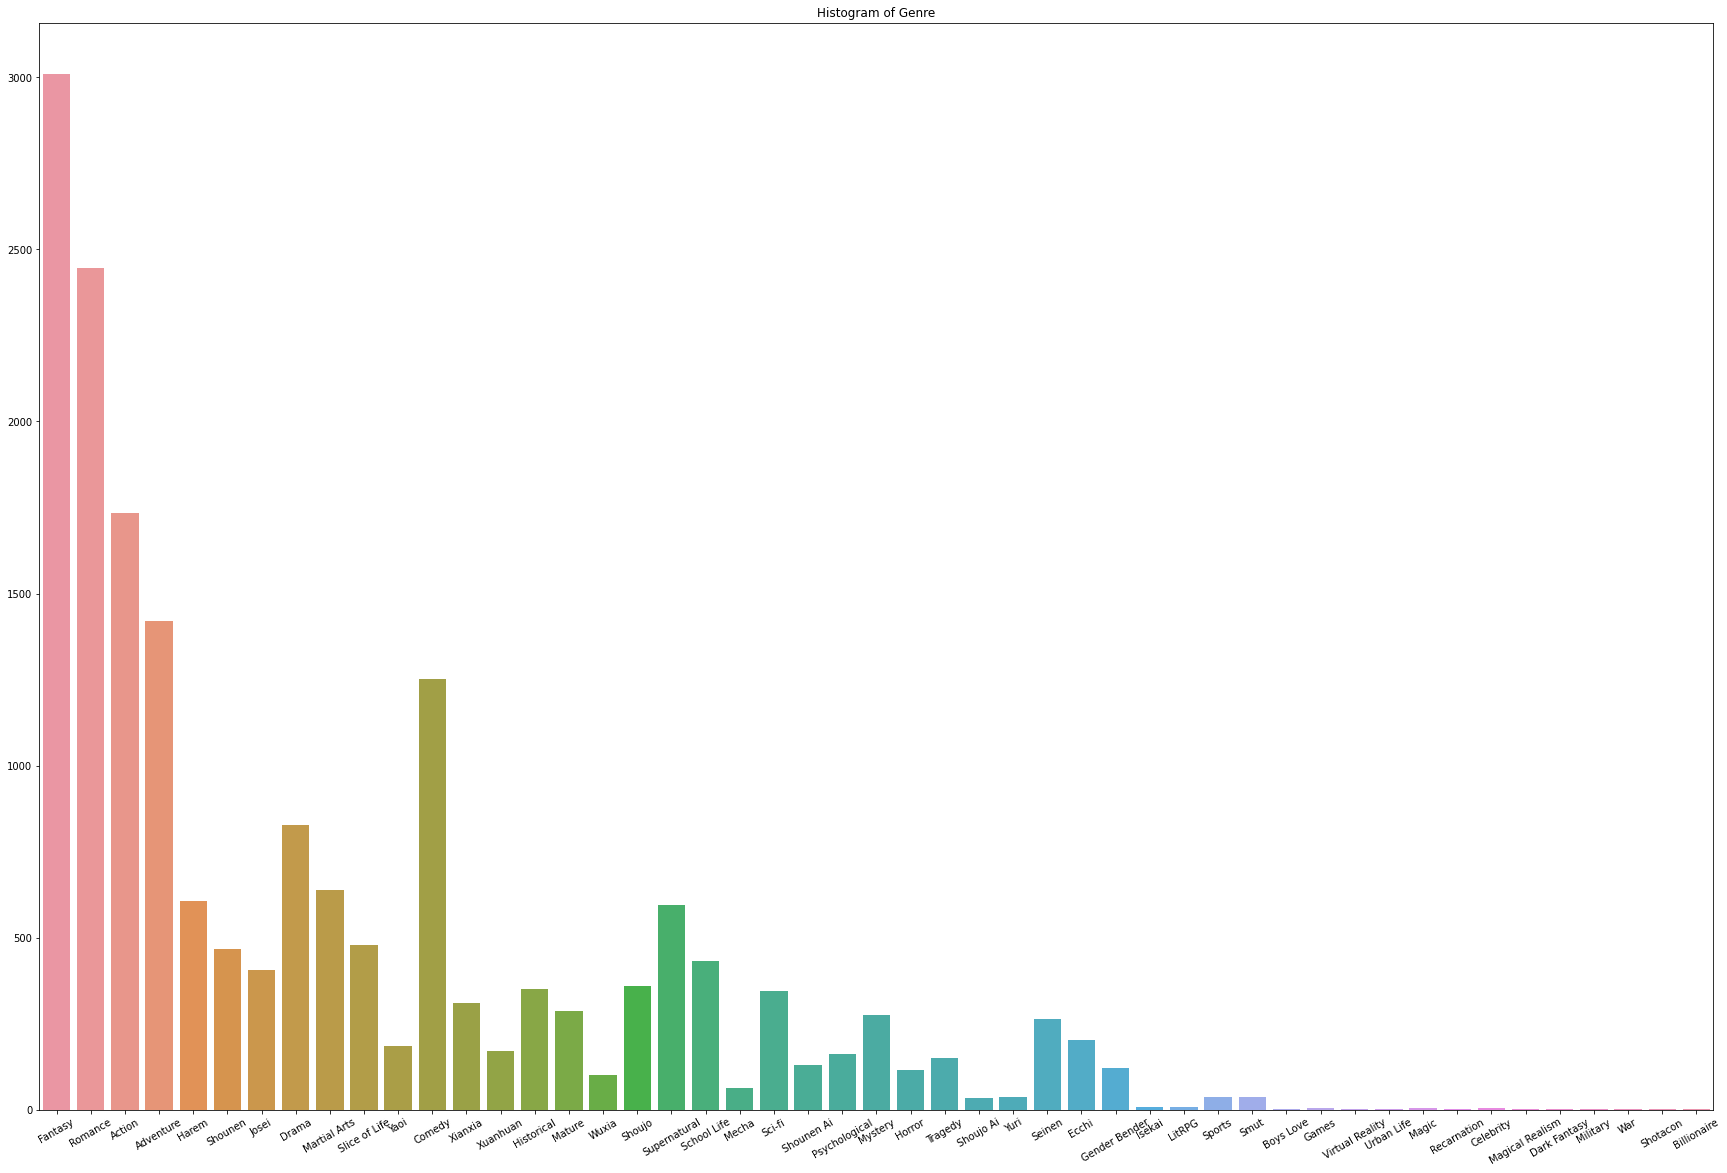

In [58]:
plt.figure(figsize=(30, 20))
plt.title('Histogram of Genre')
ax = sns.barplot(y = ln_df[[name for name in ln_df.columns if 'Genre' in name]].sum(numeric_only=True), x = [name.split('_')[-1] for name in ln_df.columns if 'Genre' in name])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.savefig('Genres.png')
plt.show()

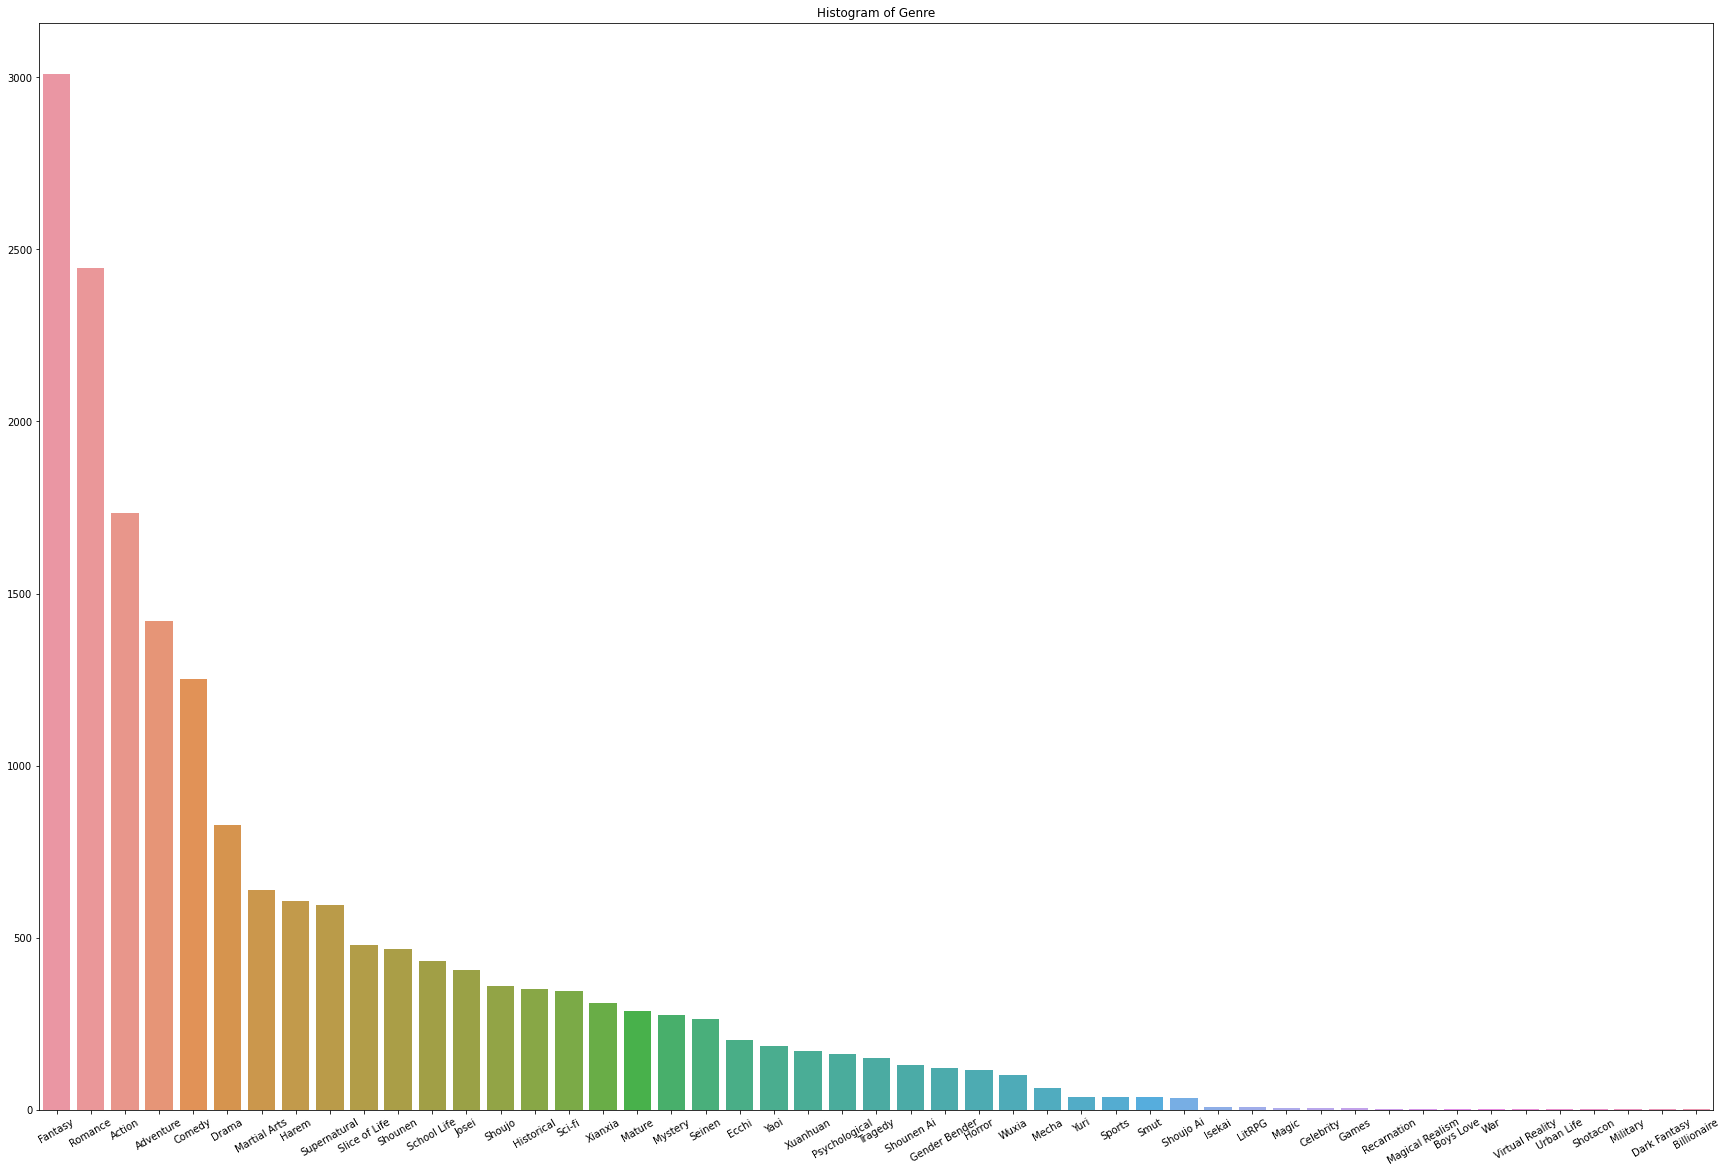

In [59]:
# Sorted histogram
y, x = zip(*sorted(zip(ln_df[[name for name in ln_df.columns if 'Genre' in name]].sum(numeric_only=True), [name.split('_')[-1] for name in ln_df.columns if 'Genre' in name]), reverse=True))
plt.figure(figsize=(30, 20))
plt.title('Histogram of Genre')
ax = sns.barplot(y = list(y),
                 x = list(x), 
                 )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.savefig('Genres.png')
plt.show()

Without much knowledge on people's preferences, seeing action, romance, fantasy, adventure, and comedy as the top most written genres makes sense. 

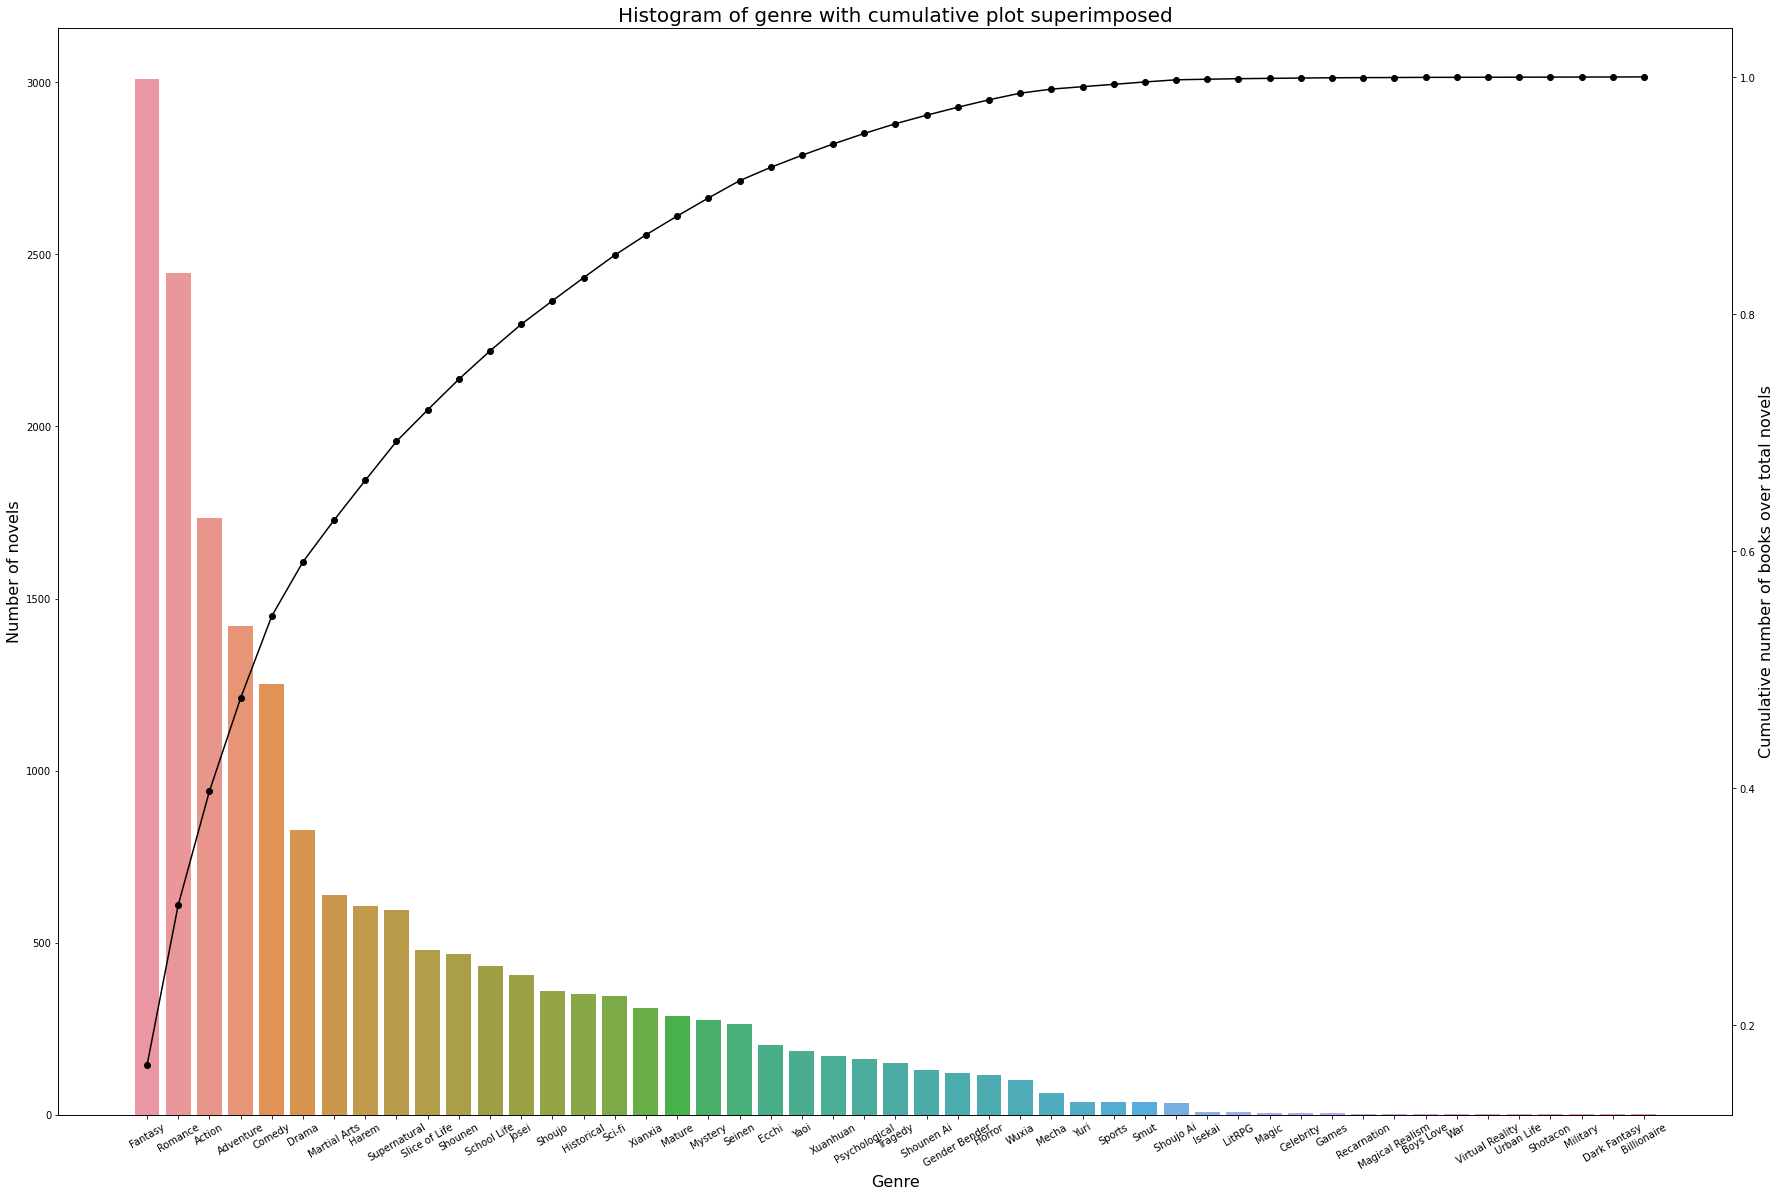

In [60]:
# Sorted histogram
y, x = zip(*sorted(zip(ln_df[[name for name in ln_df.columns if 'Genre' in name]].sum(numeric_only=True), [name.split('_')[-1] for name in ln_df.columns if 'Genre' in name]), reverse=True))
plt.figure(figsize=(30, 20))
plt.title('Histogram of genre with cumulative plot superimposed', fontsize=20)
ax = sns.barplot(y = list(y),
                 x = list(x), 
                 )
ax.set_xlabel('Genre', fontsize=16)
ax.set_ylabel('Number of novels', fontsize=16)
ax2 = plt.twinx()
ax2.set_ylabel('Cumulative number of books over total novels', fontsize=16)
cuml_y = np.cumsum(y)
plt.plot(cuml_y/cuml_y[-1], color='black', linestyle='-', marker='o')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.savefig('Genres_c.png')
plt.show()


We see again how much light novels are dominated by a small selection of genres. 

### Tags

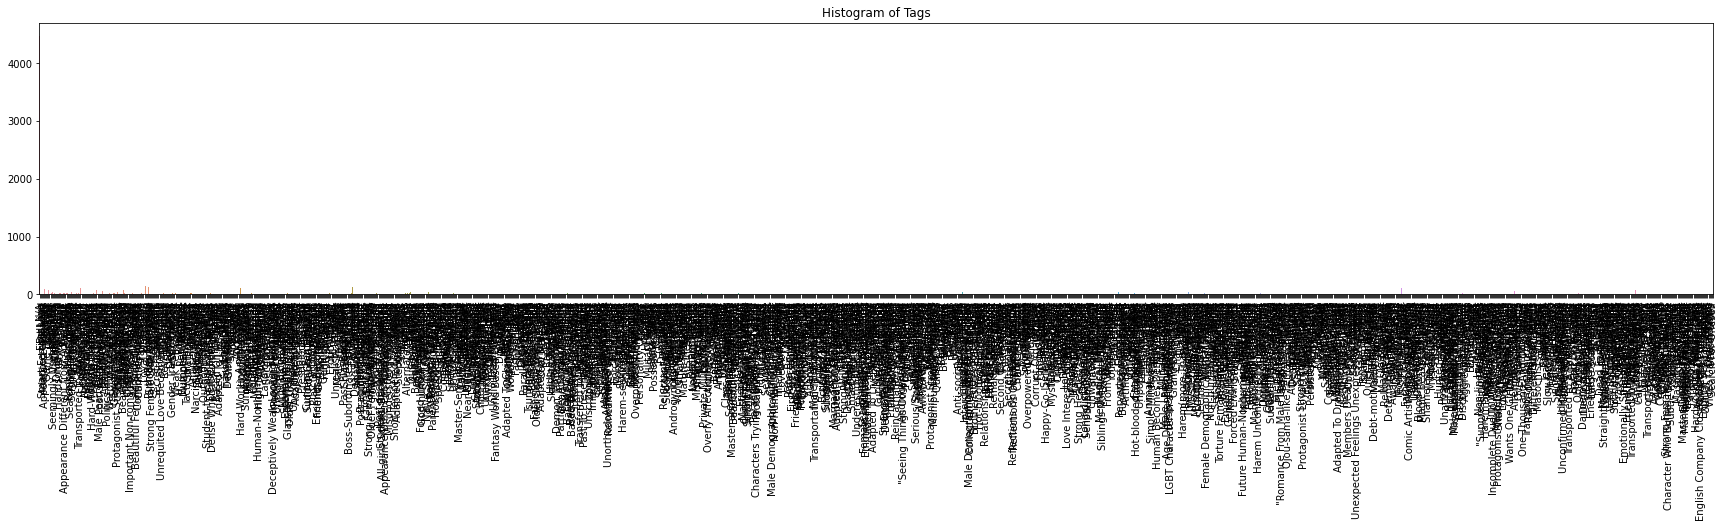

In [61]:
plt.figure(figsize=(30, 5))
plt.title('Histogram of Tags')
ax = sns.barplot(y = ln_df[[name for name in ln_df.columns if 'Tag' in name]].sum(numeric_only=True), x = [name.split('_')[-1] for name in ln_df.columns if 'Tag' in name])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig('Tags.png')
plt.show()

Too many tags! Lets take those with more than 20 mentions

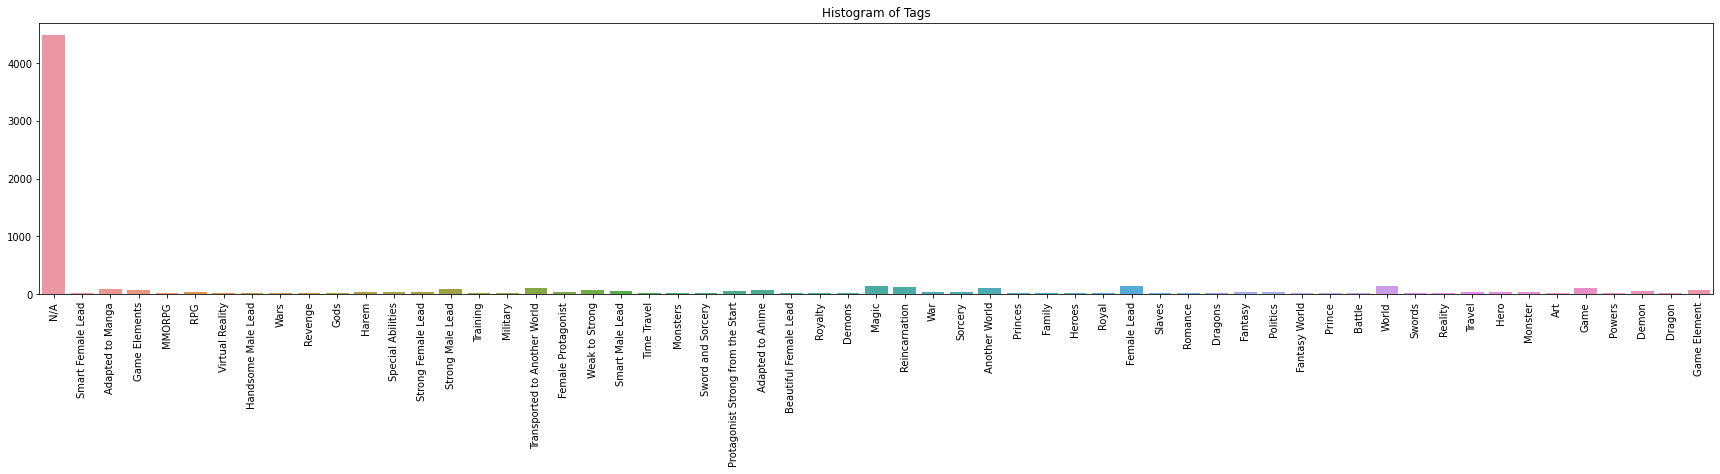

In [62]:
N = 20
tag_cols = [name for name in ln_df.columns if 'Tag' in name]
high_tag_counts = ln_df[tag_cols].loc[:, ln_df[tag_cols].sum(numeric_only=True)>N]


plt.figure(figsize=(30, 5))
plt.title('Histogram of Tags')
ax = sns.barplot(y = high_tag_counts.sum(numeric_only=True), x = [name.split('_')[-1] for name in high_tag_counts.columns if 'Tag' in name])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig(f'Tags_>{N}.png')
plt.show()

We see that the N/A tag is the most common by a long shot, so we try visualizing what happens if we exclude it

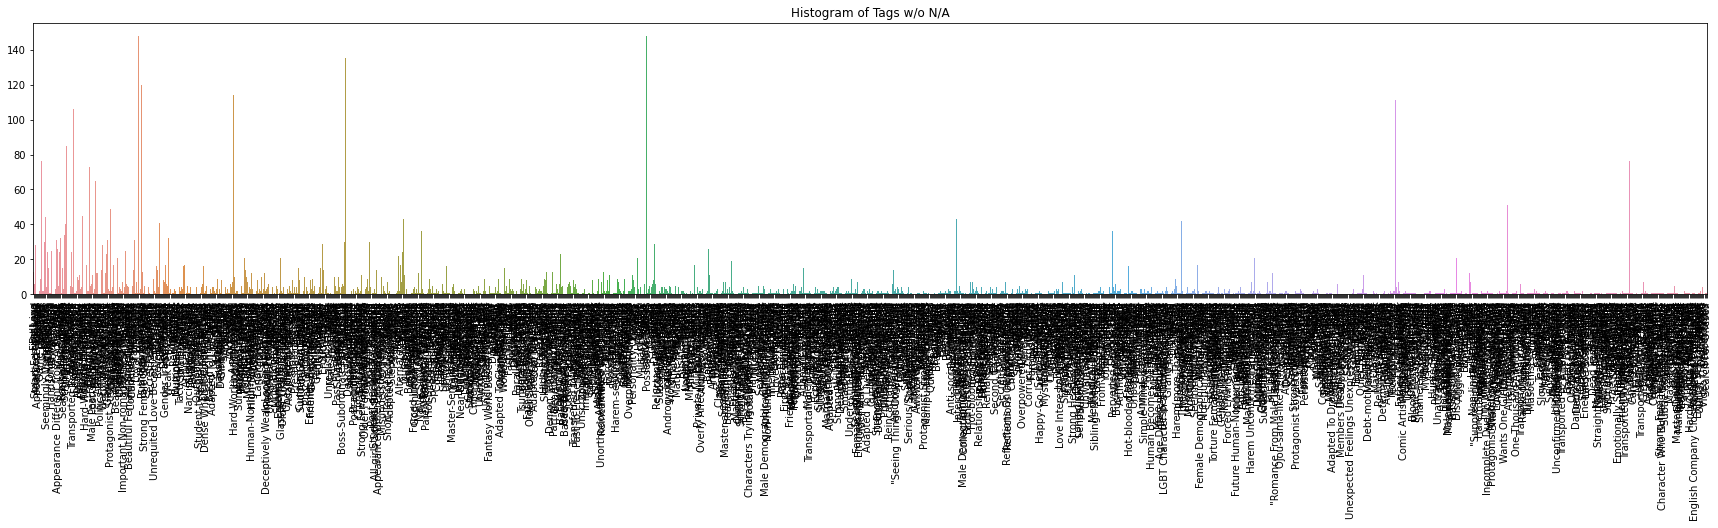

In [63]:
# Tags without N/A
plt.figure(figsize=(30, 5))
plt.title('Histogram of Tags w/o N/A')
ax = sns.barplot(y = ln_df[[name for name in ln_df.columns if (('Tag' in name) and ('N/A' not in name))]].sum(numeric_only=True), 
                 x = [name.split('_')[-1] for name in ln_df.columns if (('Tag' in name) and ('N/A' not in name))])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig('Tags_noNA.png')
plt.show()

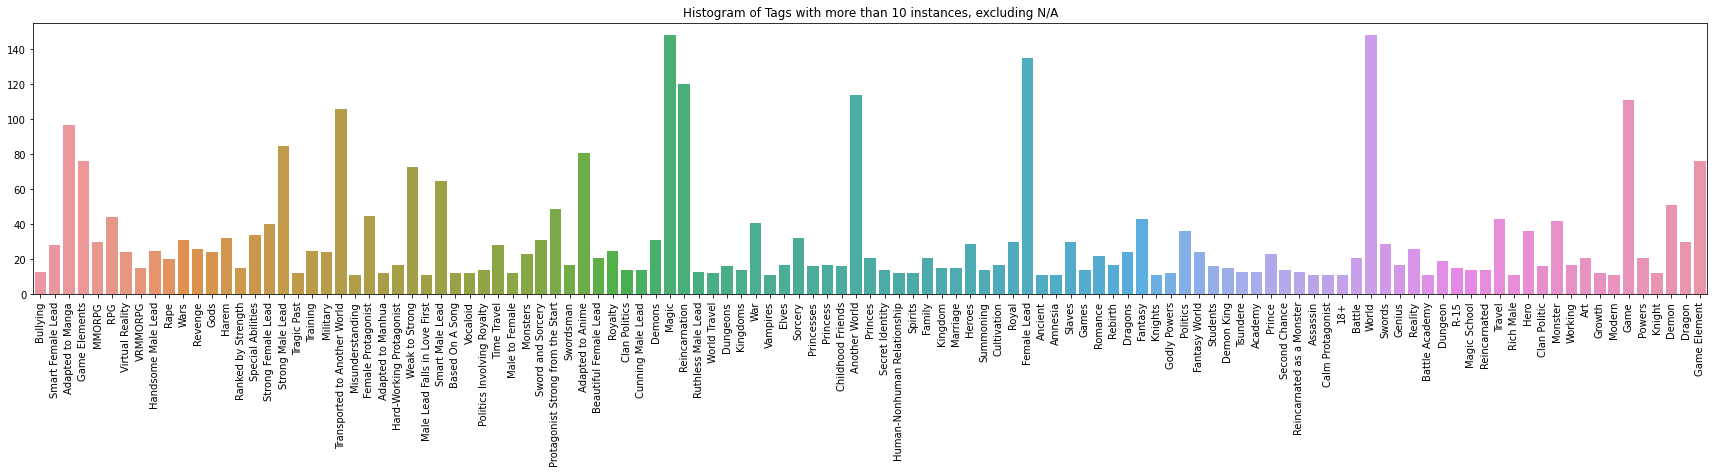

In [64]:
# Top N
N = 10
tag_cols = [name for name in ln_df.columns if (('Tag' in name) and ('N/A' not in name))]
high_tag_counts = ln_df[tag_cols].loc[:, ln_df[tag_cols].sum(numeric_only=True)>N]


plt.figure(figsize=(30, 5))
plt.title(f'Histogram of Tags with more than {N} instances, excluding N/A')
ax = sns.barplot(y = high_tag_counts.sum(numeric_only=True), x = [name.split('_')[-1].strip() for name in high_tag_counts.columns if 'Tag' in name])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig(f'Tags_>{N}_noNA.png')
plt.show()

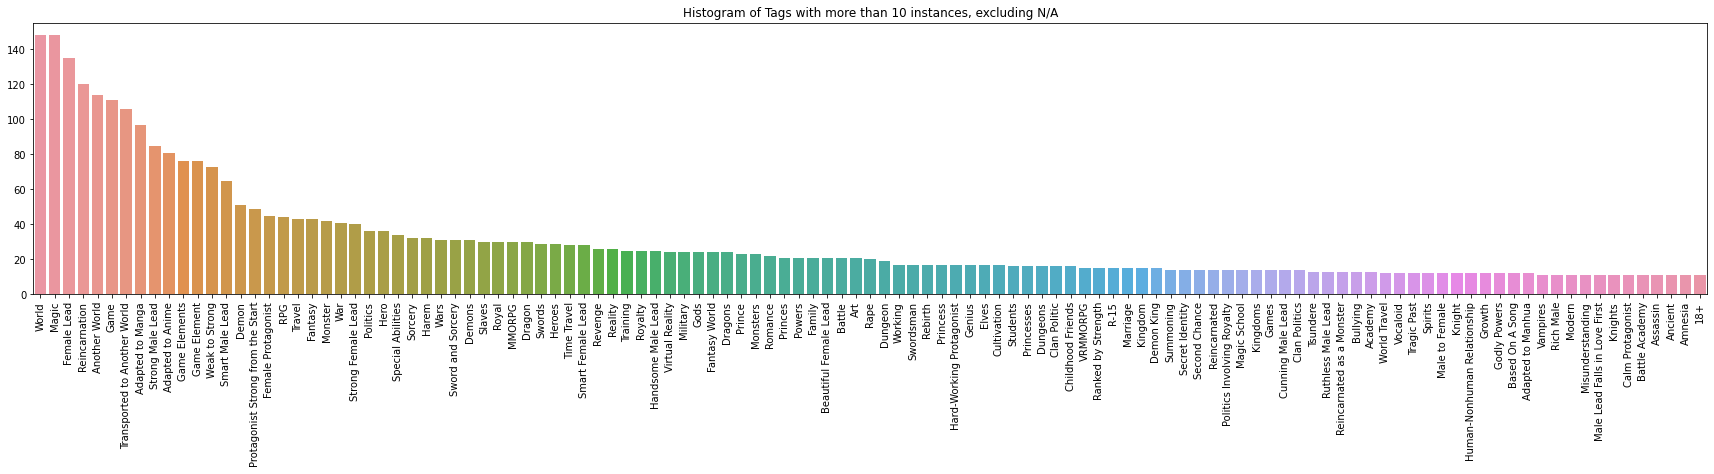

In [65]:
### Sorted 
# Top N
N = 10
tag_cols = [name for name in ln_df.columns if (('Tag' in name) and ('N/A' not in name))]
high_tag_counts = ln_df[tag_cols].loc[:, ln_df[tag_cols].sum(numeric_only=True)>N]

y, x = zip(*sorted(zip(high_tag_counts.sum(numeric_only=True), [name.split('_')[-1].strip() for name in high_tag_counts.columns if 'Tag' in name]), reverse=True))

plt.figure(figsize=(30, 5))
plt.title(f'Histogram of Tags with more than {N} instances, excluding N/A')
ax = sns.barplot(y = list(y), x = list(x))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.savefig(f'Tags_>{N}_noNA_sorted.png')
plt.show()

### Views

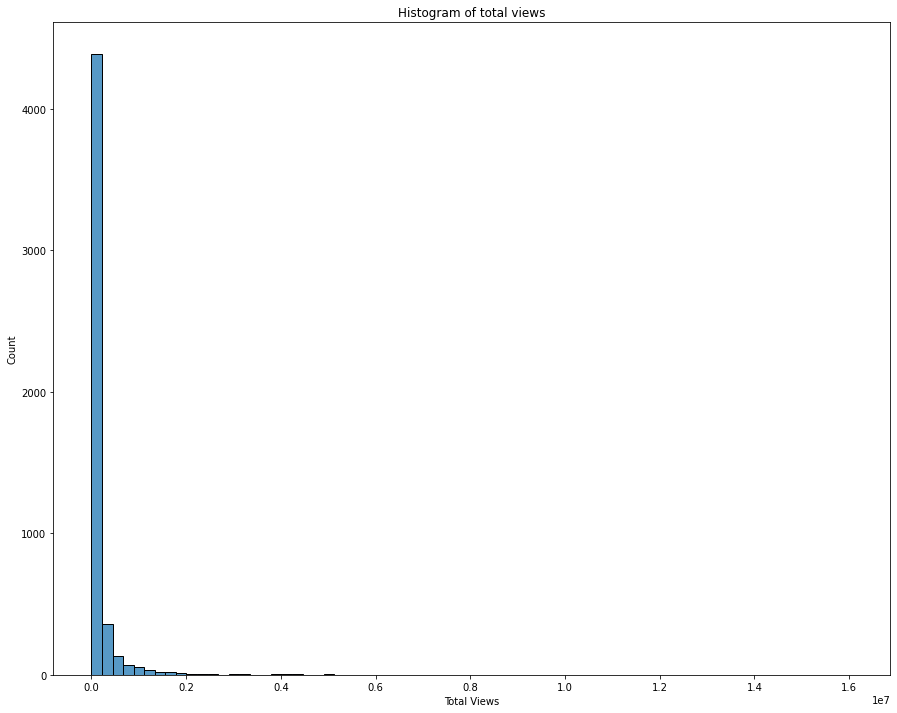

In [66]:
plt.figure(figsize=(15, 12))
plt.title(f'Histogram of total views')
sns.histplot(ln_df['Total Views'], bins = int(np.ceil(np.sqrt(len(ln_df)))))
plt.show()

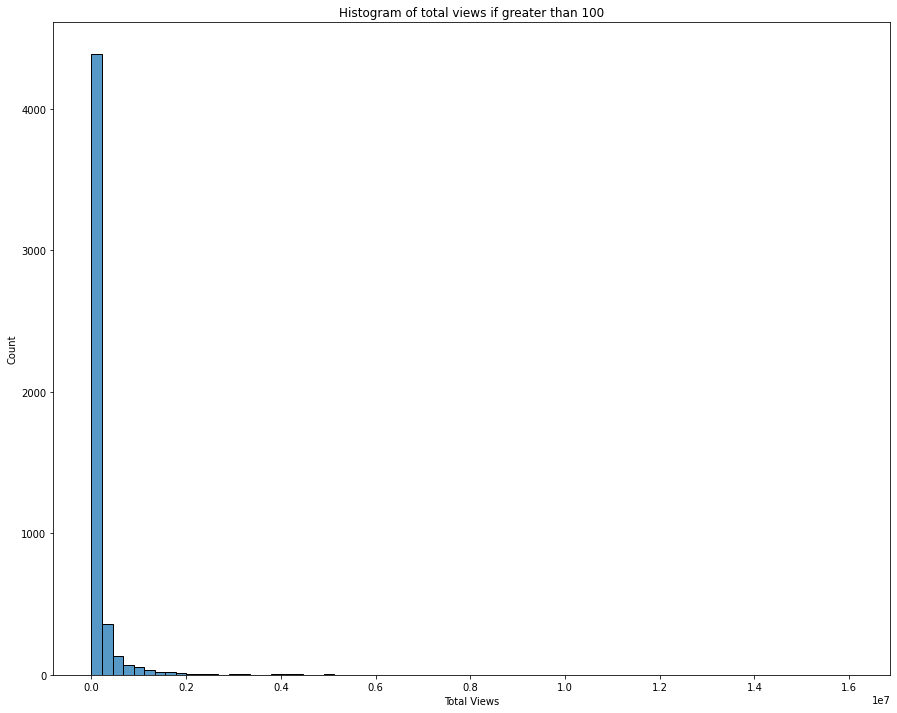

In [67]:
N = 100
plt.figure(figsize=(15, 12))
plt.title(f'Histogram of total views if greater than {N}')
sns.histplot(ln_df[ln_df['Total Views']>N]['Total Views'], bins = int(np.ceil(np.sqrt(len(ln_df)))))
plt.show()

These plots, like the chapter counts, also follow exponential decay. Here the decay happens much faster than the chapter counts though. 

It could be interesting to try to understand what the different rates imply (Are authors less likely to drop a their novel than readers are to stop reading?)

### Ratings

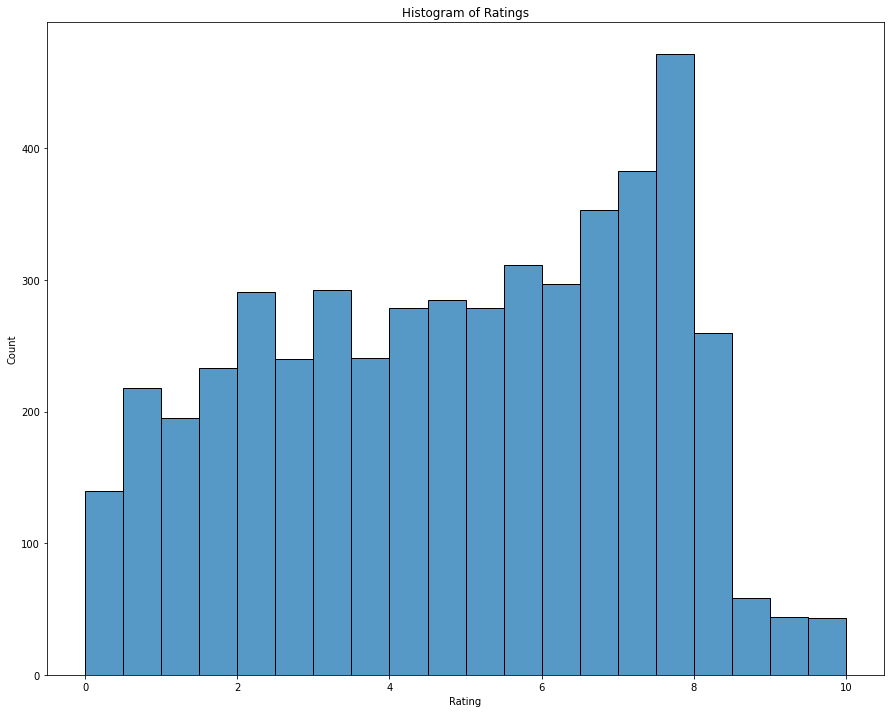

In [68]:
plt.figure(figsize=(15, 12))
plt.title(f'Histogram of Ratings')
sns.histplot(ln_df['Rating'])
plt.show()

In [69]:
ln_df['Rating'].describe()

count    4914.000000
mean        4.825071
std         2.454268
min         0.000000
25%         2.700000
50%         5.000000
75%         7.000000
max        10.000000
Name: Rating, dtype: float64

We see a left skew in the plot, meaning the mean will be lower than the median. We see that ratings don't follow a normal distribution either, and there are more novels with ratings of 7-8 than any other ratings.  

### Language

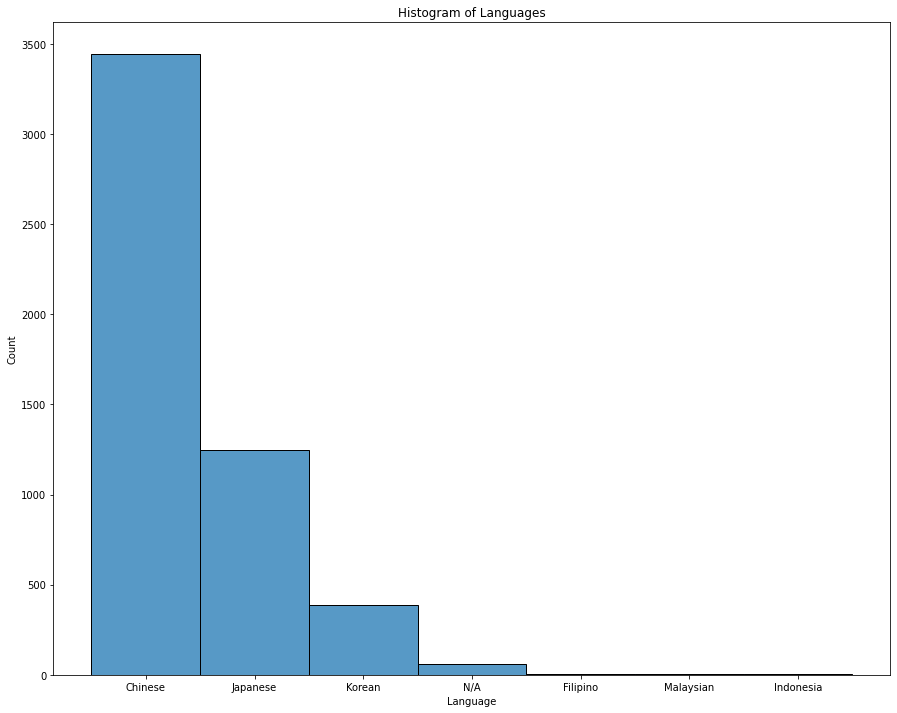

In [70]:
plt.figure(figsize=(15, 12))
plt.title(f'Histogram of Languages')
sns.histplot(ln_df['Language'])
plt.show()

This also tells us that the website mainly has chinese novels, followed by Japanese and Korean. It would be interesting to compare this histogram to one of all light novels, in which case we could say what the website favors. 

## Analysis - How to Write the best light novel

We want to figure out what features for a light novel make it easier to get views and high ratings. 

The primary KPI will be *views* - as views essentially dictate success

The secondary KPI will be *rating* - which is another metric for success, but not as direct (a novel can have high rating but people don't read it)

I am aware that more recent light novels would have less views, or that less viewed novels can be good. Choosing to focus on views makes the most sense to me, as the best novels are those that most people see (can a novel that no one reads be the best? I don't think so).


### Views and Genre

#### Let us look at the view counts for the top 3 genres

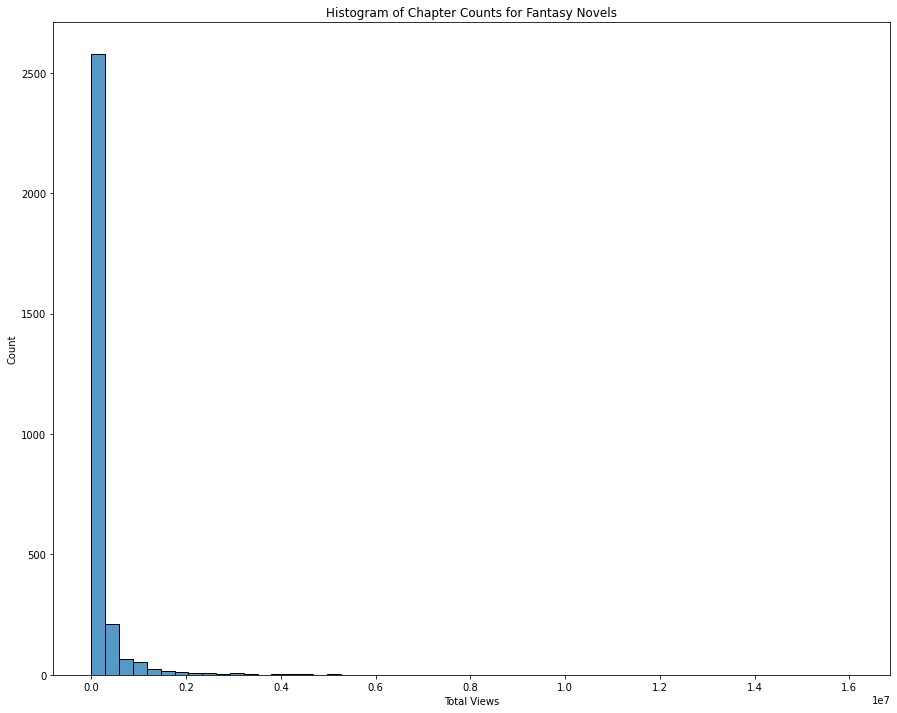

In [92]:
# Histogram of lengths
plt.figure(figsize=(15, 12))
plt.title('Histogram of Chapter Counts for Fantasy Novels')
sns.histplot(ln_df['Total Views'].where(ln_df['Genre_Fantasy']), bins = int(np.ceil(np.sqrt(ln_df['Genre_Fantasy'].sum()))))
plt.show()

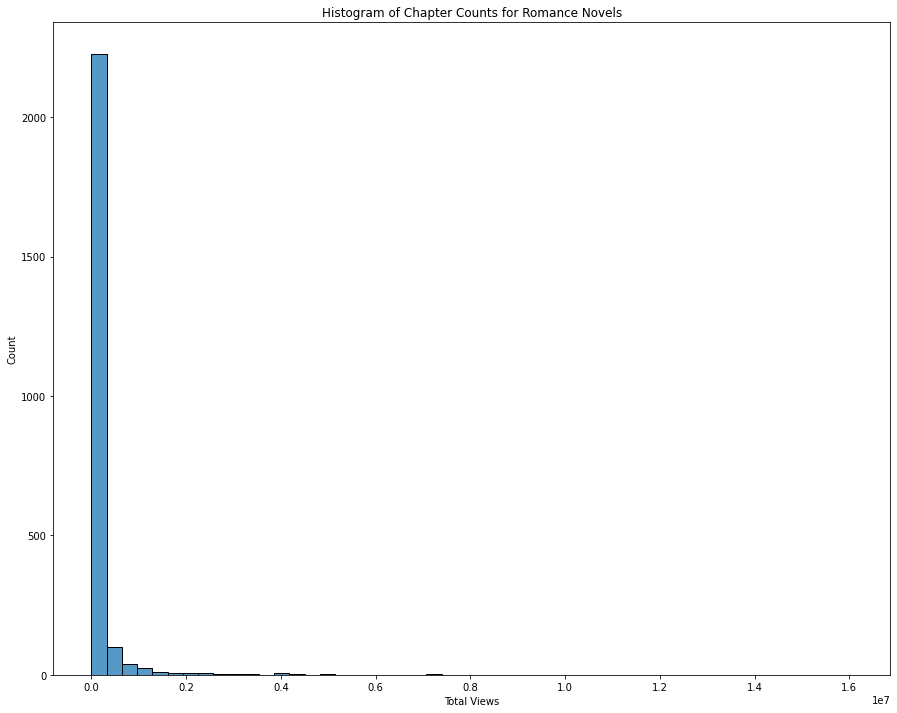

In [93]:
# Histogram of lengths
plt.figure(figsize=(15, 12))
plt.title('Histogram of Chapter Counts for Romance Novels')
sns.histplot(ln_df['Total Views'].where(ln_df['Genre_Romance']), bins = int(np.ceil(np.sqrt(ln_df['Genre_Romance'].sum()))))
plt.show()

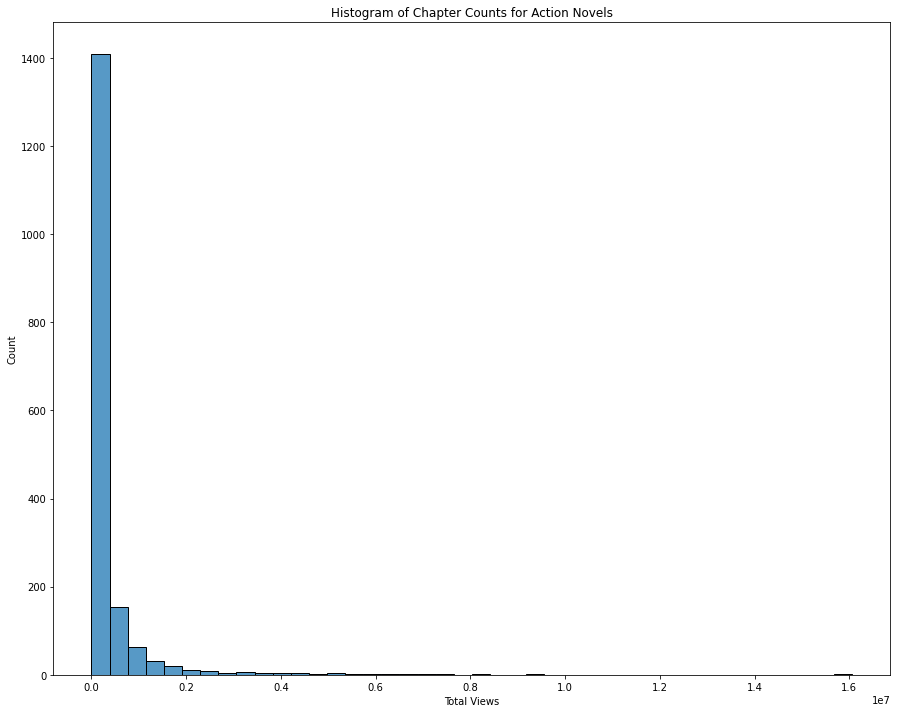

In [94]:
# Histogram of lengths
plt.figure(figsize=(15, 12))
plt.title('Histogram of Chapter Counts for Action Novels')
sns.histplot(ln_df['Total Views'].where(ln_df['Genre_Action']), bins = int(np.ceil(np.sqrt(ln_df['Genre_Action'].sum()))))
plt.show()

In [77]:
genre_views = pd.DataFrame()
for col in [name for name in ln_df.columns if 'Genre' in name]:
  genre_views[col] = ln_df['Total Views'].where(ln_df[col])
  

In [79]:
genre_views.head()

,Genre_Fantasy,Genre_Romance,Genre_Action,Genre_Adventure,Genre_Harem,Genre_Shounen,Genre_Josei,Genre_Drama,Genre_Martial Arts,Genre_Slice of Life,Genre_Yaoi,Genre_Comedy,Genre_Xianxia,Genre_Xuanhuan,Genre_Historical,Genre_Mature,Genre_Wuxia,Genre_Shoujo,Genre_Supernatural,Genre_School Life,Genre_Mecha,Genre_Sci-fi,Genre_Shounen Ai,Genre_Psychological,Genre_Mystery,Genre_Horror,Genre_Tragedy,Genre_Shoujo Ai,Genre_Yuri,Genre_Seinen,Genre_Ecchi,Genre_Gender Bender,Genre_Isekai,Genre_LitRPG,Genre_Sports,Genre_Smut,Genre_Boys Love,Genre_Games,Genre_Virtual Reality,Genre_Urban Life,Genre_Magic,Genre_Recarnation,Genre_Celebrity,Genre_Magical Realism,Genre_Dark Fantasy,Genre_Military,Genre_War,Genre_Shotacon,Genre_Billionaire
0,65133.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,56356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14834.0,14834.0,14834.0,14834.0,14834.0,14834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,26740.0,NaN,NaN,NaN,NaN,26740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24791.0,24791.0,NaN,NaN,NaN,NaN,24791.0,24791.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


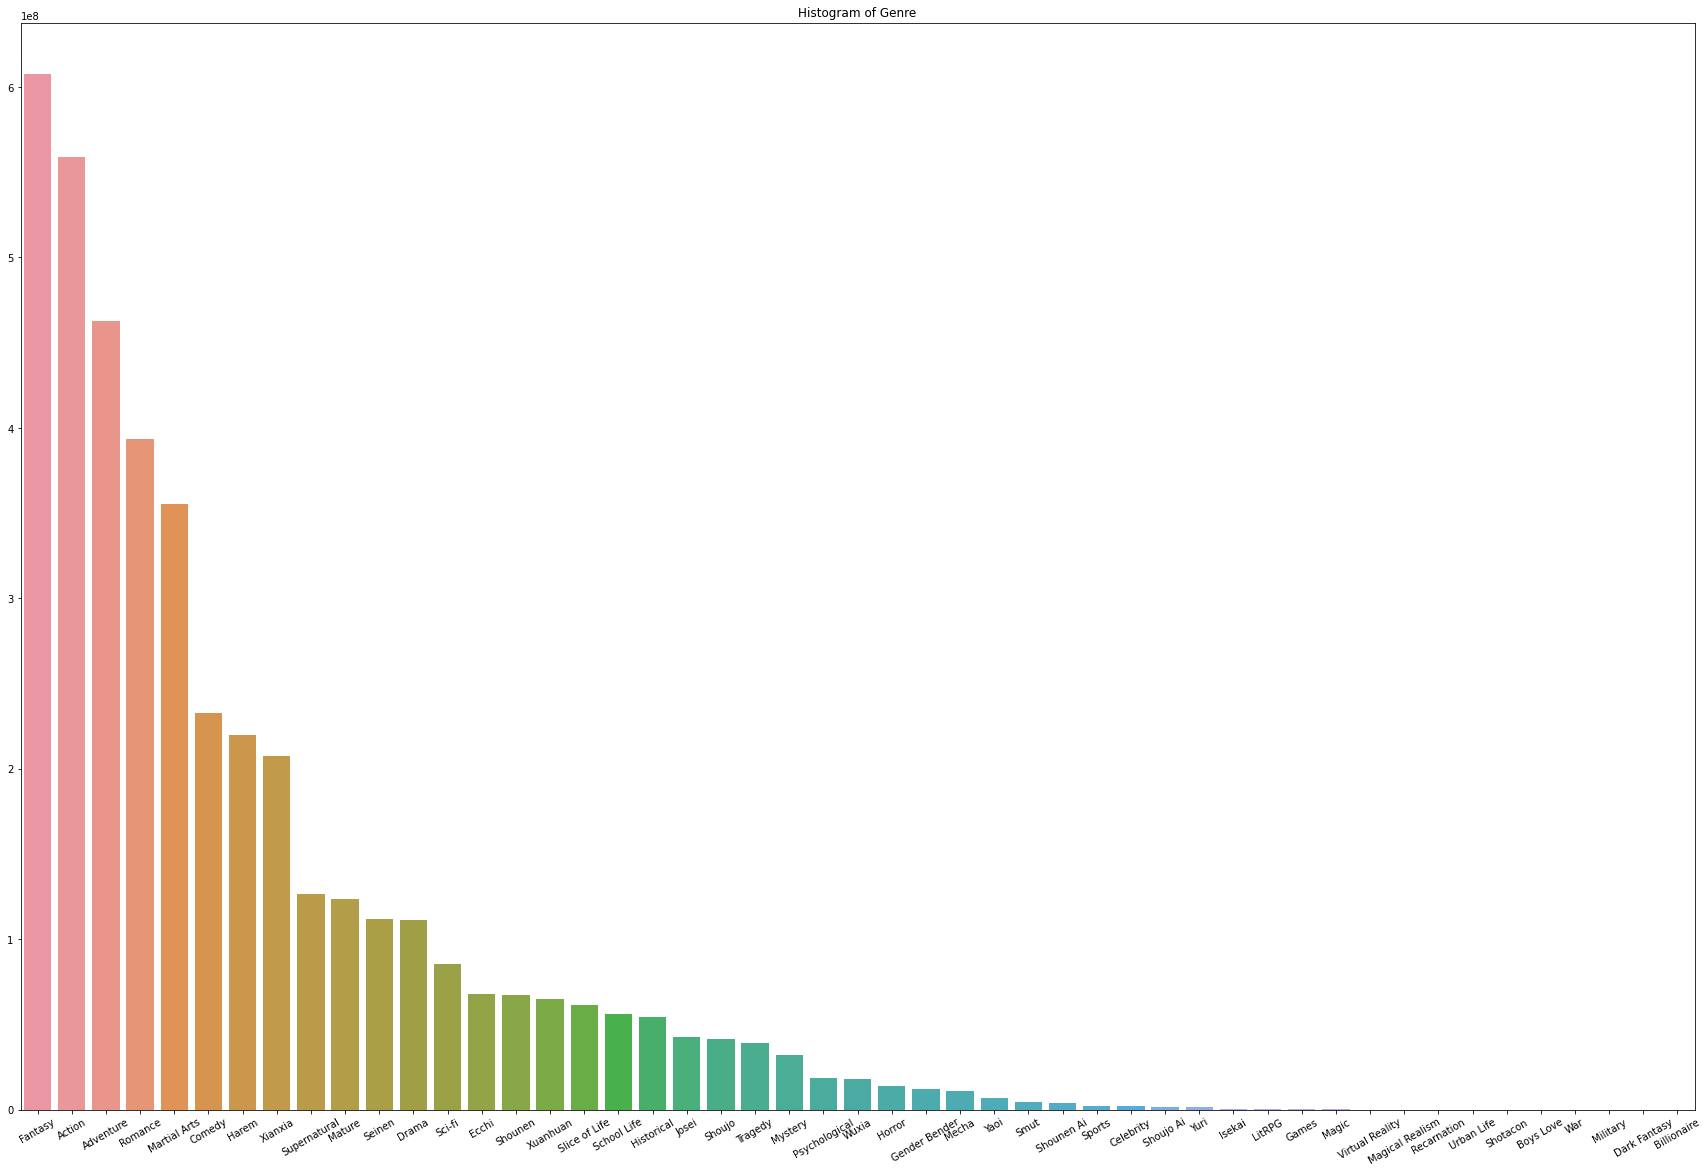

In [80]:
# Genre and views
# Sorted histogram
genre_views = genre_views[[name for name in ln_df.columns if 'Genre' in name]].sum(numeric_only=True)
y, x = zip(*sorted(zip(genre_views, [name.split('_')[-1] for name in ln_df.columns if 'Genre' in name]), reverse=True))
plt.figure(figsize=(30, 20))
plt.title('Histogram of Genre')
ax = sns.barplot(y = list(y),
                 x = list(x), 
                 )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.savefig('Genres.png')
plt.show()

Here we see what genres recieve the most views, though we are inherently biased by the number of novels in each genre

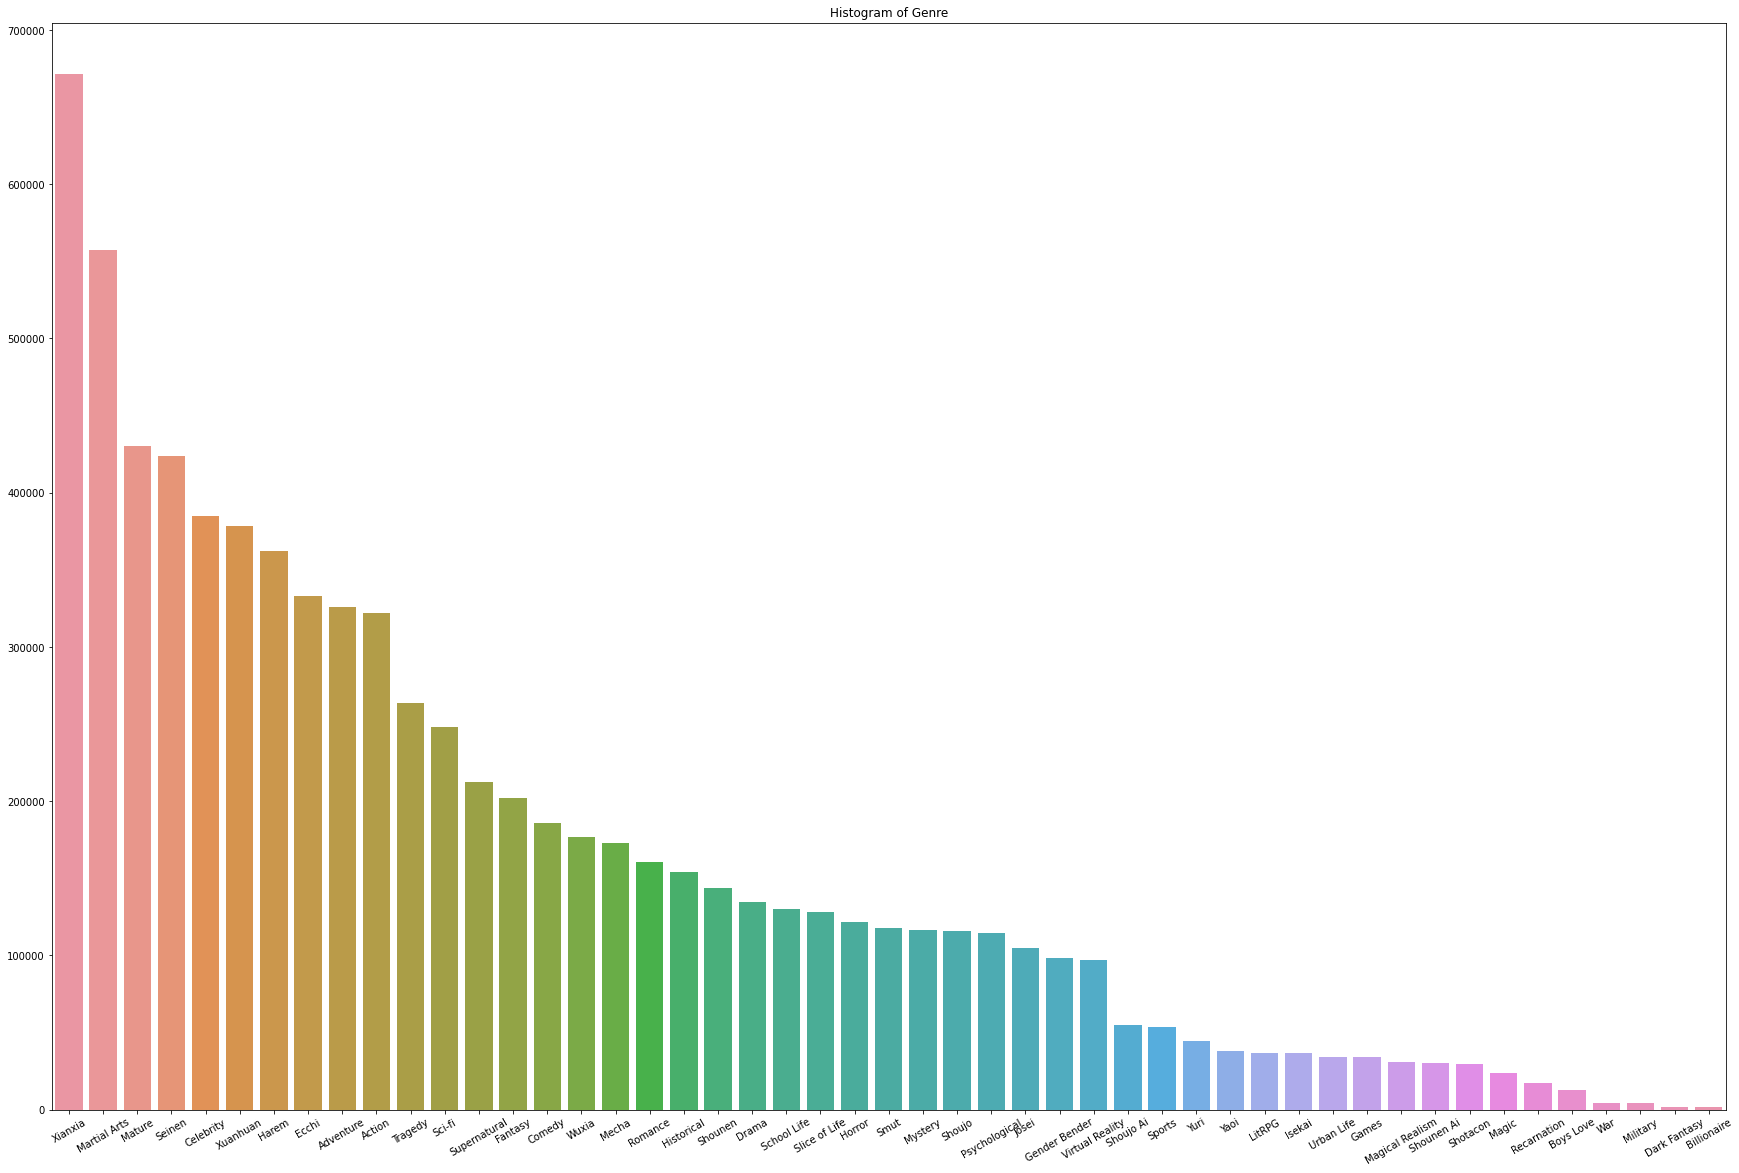

In [82]:
# Average views per light novel in Genre

# Sorted histogram
genre_views = genre_views[[name for name in ln_df.columns if 'Genre' in name]]
avg_genre_views = genre_views/ln_df[[name for name in ln_df.columns if 'Genre' in name]].sum(numeric_only=True)
y, x = zip(*sorted(zip(avg_genre_views, [name.split('_')[-1] for name in ln_df.columns if 'Genre' in name]), reverse=True))
plt.figure(figsize=(30, 20))
plt.title('Histogram of Genre')
ax = sns.barplot(y = list(y),
                 x = list(x), 
                 )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
plt.savefig('Genres.png')
plt.show()

On average, xianxia novels recieve the most views! We see that Fantasy (which was the most common genre) is not at the top anymore. 


A conclusion that we might *WANT* to draw is that Xianxia novels are the best genre to generate more views, but we can't do that yet! The results might not be significant!!

Let us investigate this some more...

We look at the histogram of the views for the xianzxia genre

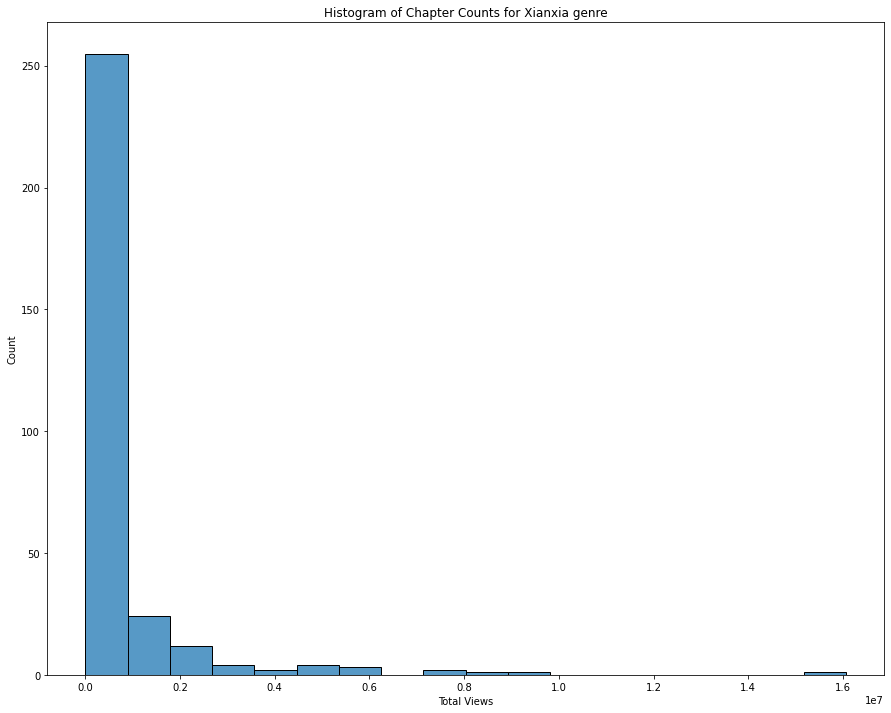

In [95]:
# Histogram 
plt.figure(figsize=(15, 12))
plt.title('Histogram of Chapter Counts for Xianxia genre')
sns.histplot(ln_df['Total Views'].where(ln_df['Genre_Xianxia']), bins = int(np.ceil(np.sqrt(ln_df['Genre_Xianxia'].sum()))))
plt.show()

The shape is very similar to the other genre specific histograms, except we see that there are a lot fewer novels in total. Let us see by how much

In [96]:
print(ln_df['Genre_Fantasy'].sum())
print(ln_df['Genre_Xianxia'].sum())

3009
309


There are roughly 10 times as many fantasy novels as there are Xianxia ones. 

We choose to perform a t-test to see if the means of the two groups are significantly different - and if they are we can conclude that it is best to write Xianxia novels (in comparison to Fantasy). 
 

In [110]:
ttest_ind(ln_df['Total Views'].where(ln_df['Genre_Xianxia']).dropna(),
                ln_df['Total Views'].where(ln_df['Genre_Fantasy']).dropna())

Ttest_indResult(statistic=10.116029432351763, pvalue=1.0322596589477957e-23)

Given p<0.05 and t-statistic>1.96, we can reject the null hypothesis and say that the means are different, and therefore Xianxia is a 'better' genre in generating views.

Source for t-test cutoff: 

https://stats.stackexchange.com/questions/250912/how-to-say-if-the-variable-is-significant-looking-only-at-t-value#:~:text=So%20if%20your%20sample%20size,meaning%20%7Ct%7C%E2%89%A51.96.

Since we did one, lets compare all the genres!

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


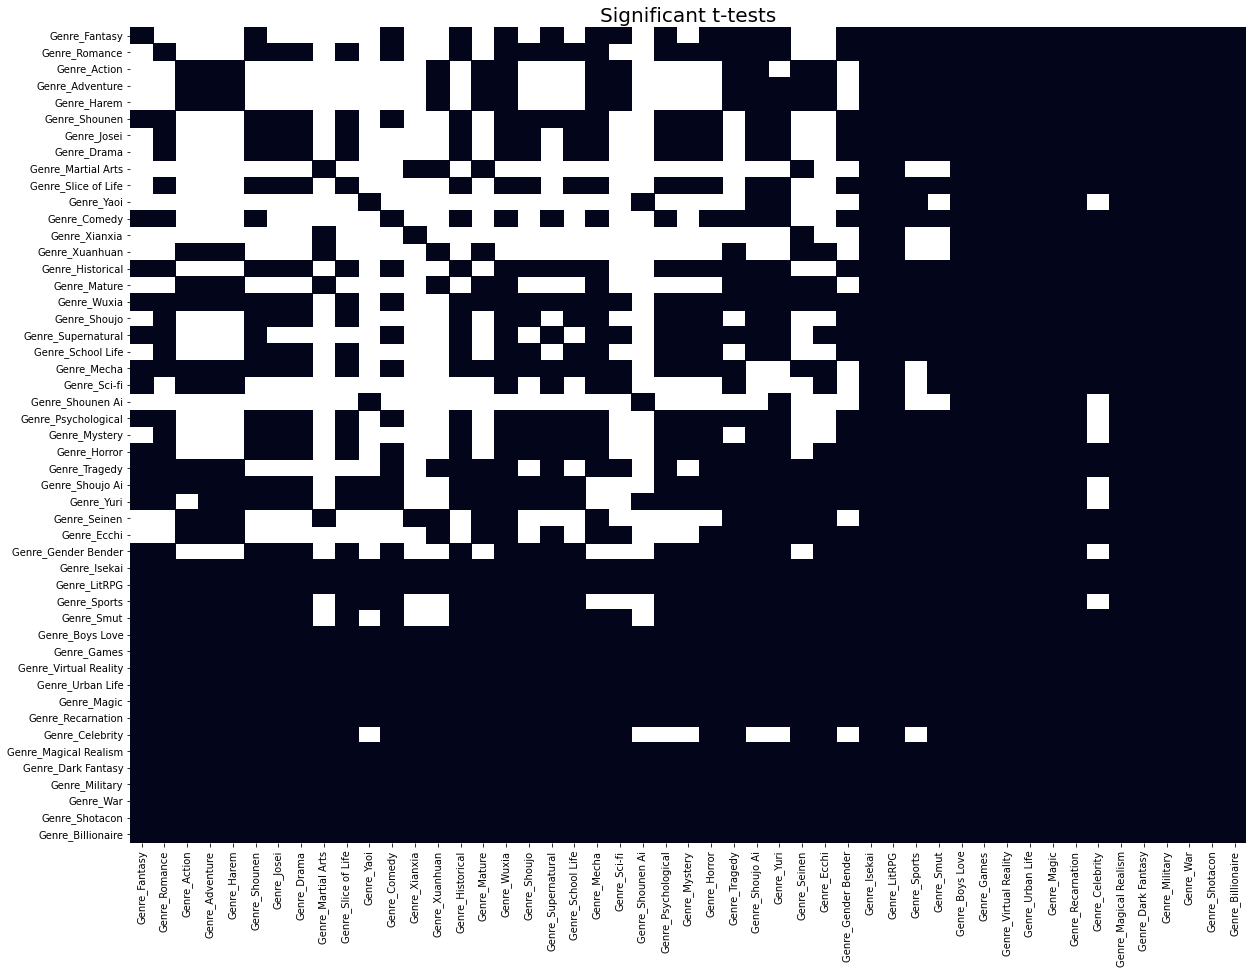

In [139]:
genres = [name for name in ln_df.columns if 'Genre' in name]

t_tests = np.zeros((2, len(genres), len(genres)))
for i, name_i in enumerate(genres):
  for j, name_j in enumerate(genres):
    t_tests[:, i, j] = ttest_ind(ln_df['Total Views'].where(ln_df[name_i]).dropna(), 
      ln_df['Total Views'].where(ln_df[name_j]).dropna())

plt.figure(figsize=(20,15))
plt.title('Significant t-tests', fontsize=20)
sns.heatmap(pd.DataFrame(np.full((len(genres), len(genres)), 100),
                         index=genres, columns=genres),
            mask=np.logical_and(t_tests[1]<0.05, np.abs(t_tests[0])>1.96), 
            cbar=False)
plt.show()

As black indicates not significant, we see that the differences between the view counts are significant between only some genres, meaning we can't state the 'best' genre. 

Despite this, the Xianxia genre does have a lot of significant t-tests, so if we were to give a best genre this would be the one (this is in consideration of earlier plots and analysis). 

**Best Genre by Views: Xianxia**